## Convert coco to Yolo

In [26]:
from ultralytics.data.converter import convert_coco
labels_dir= "C:/Users/kimin/HSC/dataset/dataset/val/"
save_dir = "C:/Users/kimin/HSC/dataset/dataset/val/labels/"
convert_coco(labels_dir, save_dir, use_segments=False)

Annotations C:\Users\kimin\HSC\dataset\dataset\val\val.json: 100%|██████████| 1957/1957 [00:01<00:00, 1635.06it/s]

COCO data converted successfully.
Results saved to C:\Users\kimin\HSC\dataset\dataset\val\labels


## Train with YOLO version 8 

In [2]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.2.2+cu121 (NVIDIA GeForce RTX 4070)


### 1. Creat Yaml file

In [1]:
import yaml

def load_yaml(file_path):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    return data

# 파일 경로
file_path = "C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/dataset.yaml"

# YAML 파일 로드
data = load_yaml(file_path)

# 데이터 출력
print(data)

{'names': ['person', 'car', 'truck', 'bus', 'bicycle', 'bike', 'extra_veichle', 'dog'], 'nc': 8, 'test': '../test/images', 'train': 'C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/train.txt', 'val': 'C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/val.txt'}


In [2]:
# train folder, test folder 생성 확인
from glob import glob
#
"""
# provided_dataset (Train: 7018, Val: 600)
train_img_list = glob('C:/Users/kimin/HSC_dataset/provided_dataset/train/images/*.png')
train_txt_list = glob('C:/Users/kimin/HSC_dataset/provided_dataset/train/labels/*.txt')
#test_img_list = glob('C:/Users/kimin/YOLO/dataset/test/images/*.png')
#test_txt_list = glob('C:/Users/kimin/YOLO/dataset/test/labels/*.txt')
valid_img_list = glob('C:/Users/kimin/HSC_dataset/provided_dataset/val/images/*.png')
valid_txt_list = glob('C:/Users/kimin/HSC_dataset/provided_dataset/val/labels/*.txt')

"""
# all_dataset (dataset + FLIR dataset -> Train: 15880, Val: 1966)
train_img_list = glob('C:/Users/kimin/HSC_dataset/all_dataset/train/images/*.png') + glob('C:/Users/kimin/HSC_dataset/all_dataset/train/images/*.jpeg')
train_txt_list = glob('C:/Users/kimin/HSC_dataset/all_dataset/train/labels/*.txt')
#test_img_list = glob('C:/Users/kimin/HSC/dataset/dataset/test/images/*.png')
#test_txt_list = glob('C:/Users/kimin/HSC/dataset/dataset/test/labels/*.txt')
valid_img_list = glob('C:/Users/kimin/HSC_dataset/all_dataset/val/images/*.png') + glob('C:/Users/kimin/HSC_dataset/all_dataset/val/images/*.jpeg')
valid_txt_list = glob('C:/Users/kimin/HSC_dataset/all_dataset/val/labels/*.txt')

#"""

print(len(train_img_list), len(valid_img_list))
print(len(train_txt_list), len(valid_txt_list))

15880 1966
14755 1957


In [3]:
# file read
with open('C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/train.txt', 'w') as f:
    f.write('\n'.join(train_img_list) + '\n')

with open('C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/val.txt', 'w') as f:
    f.write('\n'.join(valid_img_list) + '\n')

In [4]:
import yaml

with open('C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/dataset.yaml', 'r') as f:
    data = yaml.safe_load(f)

print(data)

data['train'] = 'C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/train.txt'
data['val'] = 'C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/val.txt'

with open('C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/dataset.yaml', 'w') as f:
    yaml.dump(data, f)

print(data)

{'names': ['person', 'car', 'truck', 'bus', 'bicycle', 'bike', 'extra_veichle', 'dog'], 'nc': 8, 'test': '../test/images', 'train': 'C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/train.txt', 'val': 'C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/val.txt'}
{'names': ['person', 'car', 'truck', 'bus', 'bicycle', 'bike', 'extra_veichle', 'dog'], 'nc': 8, 'test': '../test/images', 'train': 'C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/train.txt', 'val': 'C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/val.txt'}


### 2. Detection Part

In [13]:
#Check the YOLO version
import ultralytics

ultralytics.checks()

Ultralytics YOLOv8.2.92  Python-3.8.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
Setup complete  (20 CPUs, 31.8 GB RAM, 505.1/930.6 GB disk)


In [5]:
import random
import os
from ultralytics import YOLO
from PIL import Image
from blur import process_image_with_blur_and_noise  # blur.py에서 Gaussian 블러와 노이즈 함수 가져오기

# YOLO 모델 로드
model = YOLO("C:/Users/kimin/HSC/HSC-project/Yolov8/yolov8s.pt")

"""
# 데이터셋 디렉토리 설정
dataset_dir = 'C:/Users/kimin/YOLO/dataset/train/images'  # 원본 이미지 데이터셋 경로
processed_dir = 'C:/Users/kimin/YOLO/dataset/train/processed_images'  # 블러 및 노이즈 처리가 된 이미지를 저장할 디렉토리
train_txt_path = 'C:/Users/kimin/YOLO/dataset/train.txt'  # train.txt 파일 경로
new_train_txt_path = 'C:/Users/kimin/YOLO/dataset/train_augmented.txt'  # 새롭게 생성할 train 파일 경로
"""

# 데이터셋 디렉토리 설정
dataset_dir = 'C:/Users/kimin/HSC_dataset/all_dataset/train/images'  # 원본 이미지 데이터셋 경로
processed_dir = 'C:/Users/kimin/HSC_dataset/all_dataset/train/processed_images'  # 블러 및 노이즈 처리가 된 이미지를 저장할 디렉토리
train_txt_path = 'C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/train.txt'  # train.txt 파일 경로
new_train_txt_path = 'C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/train_augmented.txt'  # 새롭게 생성할 train 파일 경로

# 데이터셋에서 이미지 파일 가져오기
image_files = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg') or f.endswith('.png')]

# 데이터셋의 10% 랜덤 선택
num_images = len(image_files)
num_to_process = int(num_images * 0.1)  # 전체 이미지 중 10%만 처리
selected_images = random.sample(image_files, num_to_process)

# Blur와 Noise 처리를 적용한 이미지를 저장할 디렉토리 생성
os.makedirs(processed_dir, exist_ok=True)

blur_radius = 2  # Gaussian 블러 강도
noise_sigma = 15  # Gaussian 노이즈 강도

# train.txt 파일 읽기
with open(train_txt_path, 'r') as f:
    original_train_list = f.read().splitlines()

# 선택된 10% 이미지에 블러와 노이즈를 적용하고 저장
processed_image_paths = []
for img_file in selected_images:
    img_path = os.path.join(dataset_dir, img_file)
    
    # 이미지에 블러 및 노이즈 적용
    processed_img = process_image_with_blur_and_noise(img_path, blur_radius, noise_sigma)
    
    # 처리된 이미지 저장 경로
    processed_img_path = os.path.join(processed_dir, img_file)
    processed_img.save(processed_img_path)
    
    # 처리된 이미지 경로 저장
    processed_image_paths.append(processed_img_path)

# 새로운 train_augmented.txt 파일 생성 및 원본 이미지 + 처리된 이미지 경로 추가
with open(new_train_txt_path, 'w') as f:
    # 기존 train.txt에 있는 원본 이미지 경로 추가
    for line in original_train_list:
        f.write(line + '\n')
    
    # 처리된 이미지 경로 추가
    for processed_img_path in processed_image_paths:
        f.write(processed_img_path + '\n')

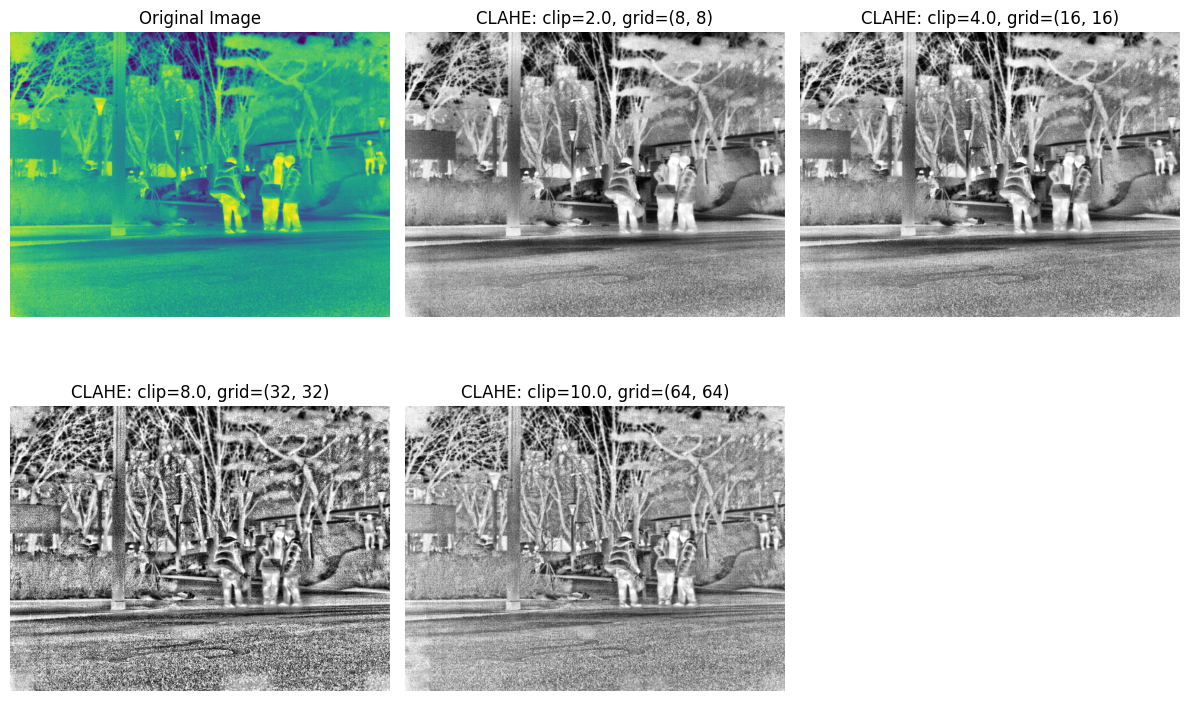

In [16]:
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 백엔드 설정: Jupyter 환경에서 시각화 문제 해결을 위해 필요할 수 있음
%matplotlib inline

# CLAHE 적용 함수
def apply_clahe(image_path, clip_limit=2.0, tile_grid_size=(8, 8)):
    # CLAHE 설정
    transform = A.Compose([
        A.CLAHE(clip_limit=clip_limit, tile_grid_size=tile_grid_size, p=1.0)  # p=1.0으로 100% 적용
    ])
    
    # 이미지 불러오기
    image = np.array(Image.open(image_path))
    
    # CLAHE 적용
    transformed = transform(image=image)
    clahe_image = transformed['image']
    
    return clahe_image

# 시각화 함수
def visualize_clahe_effects(image_path, clip_limits, tile_grid_sizes):
    plt.figure(figsize=(12, 8))

    # 원본 이미지 표시
    image = np.array(Image.open(image_path))  # Pillow 이미지를 numpy로 변환
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # 다양한 CLAHE 설정 적용하여 시각화
    for i, (clip_limit, tile_grid_size) in enumerate(zip(clip_limits, tile_grid_sizes)):
        clahe_image = apply_clahe(image_path, clip_limit=clip_limit, tile_grid_size=tile_grid_size)
        
        # 이미지가 uint8 형식으로 변환되었는지 확인 (matplotlib에서 시각화를 위해 필요)
        clahe_image = clahe_image.astype(np.uint8)
        
        plt.subplot(2, 3, i + 2)
        plt.imshow(clahe_image, cmap='gray')
        plt.title(f'CLAHE: clip={clip_limit}, grid={tile_grid_size}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 입력 이미지 경로
image_path = "C:/Users/kimin/HSC_dataset/all_dataset/train/images/train_971.png"

# 실험할 CLAHE 설정들
clip_limits = [2.0, 4.0, 8.0, 10.0]  # 대비 클립 제한 값
tile_grid_sizes = [(8, 8), (16, 16), (32, 32), (64, 64)]  # 타일 크기

# CLAHE 설정에 따른 이미지 변화 시각화
visualize_clahe_effects(image_path, clip_limits, tile_grid_sizes)


In [6]:
from ultralytics import YOLO

# Load a model
#model = YOLO('yolov10n.yaml')  # build a new model from YAML
#model = YOLO("C:/Users/kimin/YOLO/yolov8s.pt")  # load a pretrained model (recommended for training)
#model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

data_yaml = 'C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/dataset.yaml'  # 데이터셋 yaml 파일 경로

# Train the model
results = model.train(data=data_yaml, 
                      epochs=30, 
                      imgsz=640, 
                      device=0, 
                      lr0=1e-4,
                      augment=True,
                      )

Ultralytics YOLOv8.2.92  Python-3.8.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
engine\trainer: task=detect, mode=train, model=C:/Users/kimin/HSC/HSC-project/Yolov8/yolov8s.pt, data=C:/Users/kimin/HSC_dataset/all_dataset/YOLOv8/dataset.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=

train: Scanning C:\Users\kimin\HSC_dataset\all_dataset\train\labels... 14755 images, 1125 backgrounds, 0 corrupt: 100%|██████████| 15880/15880 [00:11<00:00, 1396.98it/s]


train: New cache created: C:\Users\kimin\HSC_dataset\all_dataset\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\kimin\HSC_dataset\all_dataset\val\labels.cache... 1957 images, 9 backgrounds, 0 corrupt: 100%|██████████| 1966/1966 [00:00<?, ?it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.45G      1.296      1.141       1.05         96        640: 100%|██████████| 993/993 [02:05<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:09<00:00,  6.64it/s]

                   all       1966      16160      0.746       0.38      0.445      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.09G      1.242     0.8133      1.028        157        640:  12%|█▏        | 119/993 [00:14<01:46,  8.20it/s]


KeyboardInterrupt: 

In [18]:
!pip show ultralytics
!pip install ultralytics --upgrade

Name: ultralytics
Version: 8.0.228
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: c:\users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, thop, torch, torchvision, tqdm
Required-by: 
     ---------------------------------------- 0.0/41.3 kB ? eta -:--:--
     -------------------------------------- 41.3/41.3 kB 661.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/869.1 kB ? eta -:--:--
   ---------------------- ---------------- 491.5/869.1 kB 10.5 MB/s eta 0:00:01
   --------------------------------------- 869.1/869.1 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultra

## Inference Part (YOLOv8n.pt - best model)

### 3. Predict test_open dataset

In [37]:
from ultralytics import YOLO
import os


model = YOLO("C:/Users/kimin/HSC/runs/detect/train5/weights/best.pt") # 원하는 모델

results = model.predict("C:/Users/kimin/HSC/dataset/test_open/", save=True, conf=0.15)

# 결과를 저장할 폴더 경로 설정
save_dir = "C:/Users/kimin/YOLO/dataset/results/result_3"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 결과를 txt 파일로 저장
for result in results:
    # 이미지 파일명 추출
    image_name = os.path.splitext(os.path.basename(result.path))[0]
    
    # 저장할 txt 파일 경로 설정
    txt_path = os.path.join(save_dir, f"{image_name}.txt")
    
    with open(txt_path, 'w') as f:
        # 각 예측된 객체의 정보를 txt에 기록
        for box in result.boxes:
            class_id = int(box.cls)  # 클래스 ID
            confidence = box.conf.item()  # 신뢰도
            x1, y1, x2, y2 = box.xyxy[0].tolist()  # 바운딩 박스 좌표 (좌상단 x1, y1, 우하단 x2, y2)

            # width와 height 계산
            width = x2 - x1
            height = y2 - y1

            # 원하는 형식: class_id x1 y1 width height confidence
            f.write(f"{class_id} {x1:.2f} {y1:.2f} {width:.2f} {height:.2f} {confidence:.2f}\n")

print(f"결과가 {save_dir} 폴더에 저장되었습니다.")



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1636 C:\Users\kimin\HSC\dataset\test_open\test_open_0.png: 480x640 1 car, 1 truck, 35.1ms
image 2/1636 C:\Users\kimin\HSC\dataset\test_open\test_open_1.png: 480x640 1 car, 26.0ms
image 3/1636 C:\Users\kimin\HSC\dataset\test_open\test_open_10.png: 480x640 (no detections), 34.5ms
image 4/1636 C:\Users\kimin\HSC\dataset\test_open\test_open_100.png: 480x640 1 person, 2 cars, 7.0ms
image 5/1636 C:\Users\kimin\HSC\dataset\test_open\test_open_1000.png: 

### 4. Convert Prediction file results

In [38]:
import os
import json
import re

# 결과가 저장된 폴더 경로 (이 폴더에서 txt 파일을 읽어옵니다)
save_dir = "C:/Users/kimin/YOLO/dataset/results/result_3"

# 최종 결과를 저장할 리스트
output_data = []

# 자연 정렬을 위한 함수 정의
def natural_sort_key(file_name):
    # 숫자가 포함된 부분을 기준으로 정렬
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', file_name)]

# 결과 폴더 내 모든 txt 파일을 자연 정렬하여 읽기
txt_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".txt")], key=natural_sort_key)

# txt 파일에서 데이터를 읽어와 결과 리스트 생성
for txt_file in txt_files:
    # 파일명에서 확장자 제거하여 image_id 생성
    image_id = os.path.splitext(txt_file)[0]
    
    # txt 파일 경로
    txt_path = os.path.join(save_dir, txt_file)
    
    # txt 파일 읽기
    with open(txt_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # 각 라인의 데이터를 분해 (class_id, x1, y1, width, height, confidence)
            parts = line.strip().split()
            category_id = int(parts[0])
            x1 = float(parts[1])
            y1 = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            score = float(parts[5])

            # 결과를 원하는 형식으로 리스트에 추가
            output_data.append({
                "image_id": image_id,
                "category_id": category_id,
                "bbox": [round(x1, 2), round(y1, 2), round(width, 2), round(height, 2)],
                "score": round(score, 5)
            })

# 결과를 저장할 경로 지정 (다른 폴더에 저장하도록 경로 설정)
output_dir = "C:/Users/kimin/YOLO/dataset/sub_file"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 결과 파일 이름 설정 (중복 확인 후 새로운 파일 이름 생성)
base_filename = "result_3"
extension = ".txt"
result_path = os.path.join(output_dir, base_filename + extension)

# 파일이 이미 존재하는지 확인하고, 숫자를 추가하여 중복 방지
counter = 1
while os.path.exists(result_path):
    result_path = os.path.join(output_dir, f"{base_filename}_{counter}{extension}")
    counter += 1

# 결과를 result.txt 또는 다른 이름으로 저장
with open(result_path, 'w') as result_file:
    result_file.write(json.dumps(output_data, indent=4))

print(f"결과가 {result_path}에 저장되었습니다.")

결과가 C:/Users/kimin/YOLO/dataset/sub_file\result_3.txt에 저장되었습니다.


In [4]:
!pip freeze -r requirements.txt

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pip\_internal\cli\base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pip\_internal\commands\freeze.py", line 98, in run
    for line in freeze(
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pip\_internal\operations\freeze.py", line 43, in freeze
    req = FrozenRequirement.from_dist(dist)
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pip\_internal\operations\freeze.py", line 238, in from_dist
    req, comments = _get_editable_info(dist)
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-packages\pip\_internal\operations\freeze.py", line 165, in _get_editable_info
    vcs_backend = vcs.get_backend_for_dir(location)
  File "C:\Users\kimin\anaconda3\envs\yolo-strongsort_env\lib\site-p